In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import *

In [2]:
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)

cuda


In [4]:
#데이터 불러오기
path = 'https://bit.ly/advertising_csv'
adv = pd.read_csv(path)

# x,y 분할
target = 'Sales'
x = adv.drop(target, axis=1)
y = adv.loc[:,target]

x_train, x_val, y_train, y_val = train_test_split(x,y,test_size=.2, random_state=20)

print(type(x_train), type(x_val))

# 스케일링
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
print(type(x_train), type(x_val))

<class 'pandas.DataFrame'> <class 'pandas.DataFrame'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [6]:
# 텐서 변환

x_train_ts = torch.tensor(x_train, dtype=torch.float32)
y_train_ts = torch.tensor(y_train.values, dtype=torch.float32).view(-1,1)
x_val_ts = torch.tensor(x_val, dtype=torch.float32)
y_val_ts = torch.tensor(y_val.values, dtype=torch.float32).view(-1,1)

# 디바이스 할당
x_train_ts, y_train_ts = x_train_ts.to(device), y_train_ts.to(device)
x_val_ts, y_val_ts = x_val_ts.to(device), y_val_ts.to(device)

In [7]:
BATCH_SIZE = 32
train_ds = TensorDataset(x_train_ts, y_train_ts)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
in_features = x_train_ts.shape[1]
model = nn.Sequential(
    nn.Linear(in_features, 1),
).to(device)

In [9]:
loss_fn = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.01)

In [11]:
EPOCHS = 100
tr_loss_list, val_loss_list = [], []

# 1. 학습 데이터 반복 학습
for epoch in range(EPOCHS):
    model.train() # 모델 학습 로드
    total_loss = 0.0
    n_batch = 0

    # 2. 에포크마다 배치 단위 학습
    for x,y in train_loader:
        x,y = x.to(device), y.to(device)

        # 3. 학습
        # 오차 순전ㅊ파: 학습 데이터에서 오차 계산
        pred = model(x)
        loss = loss_fn(pred, y)

        # 오차 역전파: 오차로부터 가중치 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        n_batch += 1
    
    # 에폭마다 학습 오차 집계
    tr_loss = total_loss / n_batch

    model.eval()
    with torch.no_grad():
        val_pred = model(x_val_ts)
        val_loss = loss_fn(val_pred, y_val_ts)
    
    tr_loss_list.append(tr_loss)
    val_loss_list.append(val_loss)
    print(f'Epoch {epoch+1:4d}  | train loss {tr_loss:.4f} | val loss {val_loss:.4f}')


Epoch    1  | train loss 234.9398 | val loss 244.0828
Epoch    2  | train loss 231.5204 | val loss 240.6295
Epoch    3  | train loss 228.1186 | val loss 237.2155
Epoch    4  | train loss 224.7804 | val loss 233.8274
Epoch    5  | train loss 221.4335 | val loss 230.4781
Epoch    6  | train loss 218.0881 | val loss 227.1769
Epoch    7  | train loss 214.8511 | val loss 223.8970
Epoch    8  | train loss 211.5829 | val loss 220.6644
Epoch    9  | train loss 208.4489 | val loss 217.4441
Epoch   10  | train loss 205.2408 | val loss 214.2804
Epoch   11  | train loss 202.1554 | val loss 211.1364
Epoch   12  | train loss 199.1022 | val loss 208.0190
Epoch   13  | train loss 196.0426 | val loss 204.9462
Epoch   14  | train loss 192.9881 | val loss 201.9272
Epoch   15  | train loss 190.0594 | val loss 198.9253
Epoch   16  | train loss 187.1065 | val loss 195.9656
Epoch   17  | train loss 184.1688 | val loss 193.0562
Epoch   18  | train loss 181.3342 | val loss 190.1669
Epoch   19  | train loss 178

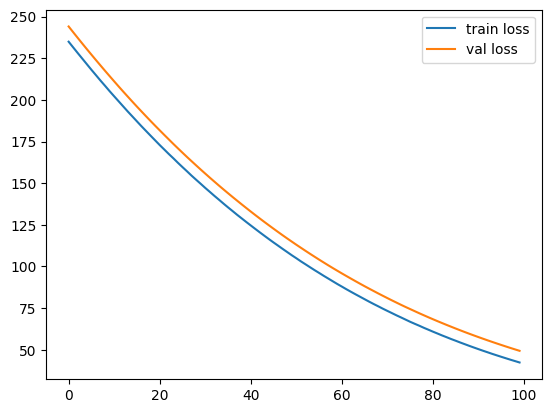

In [14]:
plt.plot([x.cpu().item() if isinstance(x, torch.Tensor) else x for x in tr_loss_list], label='train loss')
plt.plot([x.cpu().item() if isinstance(x, torch.Tensor) else x for x in val_loss_list], label='val loss')
plt.legend()
plt.show()

In [16]:
# 예측

model.eval()



with torch.no_grad():
    pred_val = model(x_val_ts).cpu().numpy()
true_val = y_val_ts.cpu().numpy()
# 평가
print(f'RMSE: {root_mean_squared_error(true_val, pred_val):.4f}')
print(f'MAE: {mean_absolute_error(true_val, pred_val):.4f}')
print(f'R2: {r2_score(true_val, pred_val):.4f}')

RMSE: 7.0278
MAE: 5.8861
R2: -0.3647
